In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [17]:
R_earth = 6.371e6
M_earth = 5.972e24

In [18]:
# scale factor, log axis, unit name
units = {
    "p_boa"         : [1e-5,      True   ,"bar"],
    "p_surf"        : [1,         True   ,"bar"],
    "tmp_surf"      : [1,         False  ,"K"],
    "transspec_r"   : [1/R_earth, False  ,r"R$_\oplus$"],
    "transspec_rho" : [0.001,     False  ,"g/cm3"],
    "transspec_μ"   : [1e3,       False  ,"g/mol"],
    "mmw_surf"      : [1e3,       False  ,"g/mol"],
    "transspec_tmp" : [1,         False  ,"K"],
    "Kzz_kbreak"    : [1e4,       False   ,"cm2/s"],
    "mass"          : [1/M_earth, False   ,r"M$_\oplus$"],
}

In [19]:

# Read the CSV files
output_dir = "../out"
gridpoints_df = pd.read_csv(os.path.join(output_dir, "gridpoints.csv"), sep=',')
results_df = pd.read_csv(os.path.join(output_dir, "result.csv"), sep=',')

# Merge the dataframes on index
data = pd.merge(gridpoints_df, results_df, on="index")

# Define input and output variables
input_vars  = list(gridpoints_df.keys())
output_vars = list(results_df.keys())

input_vars.remove("index")
output_vars.remove("index")

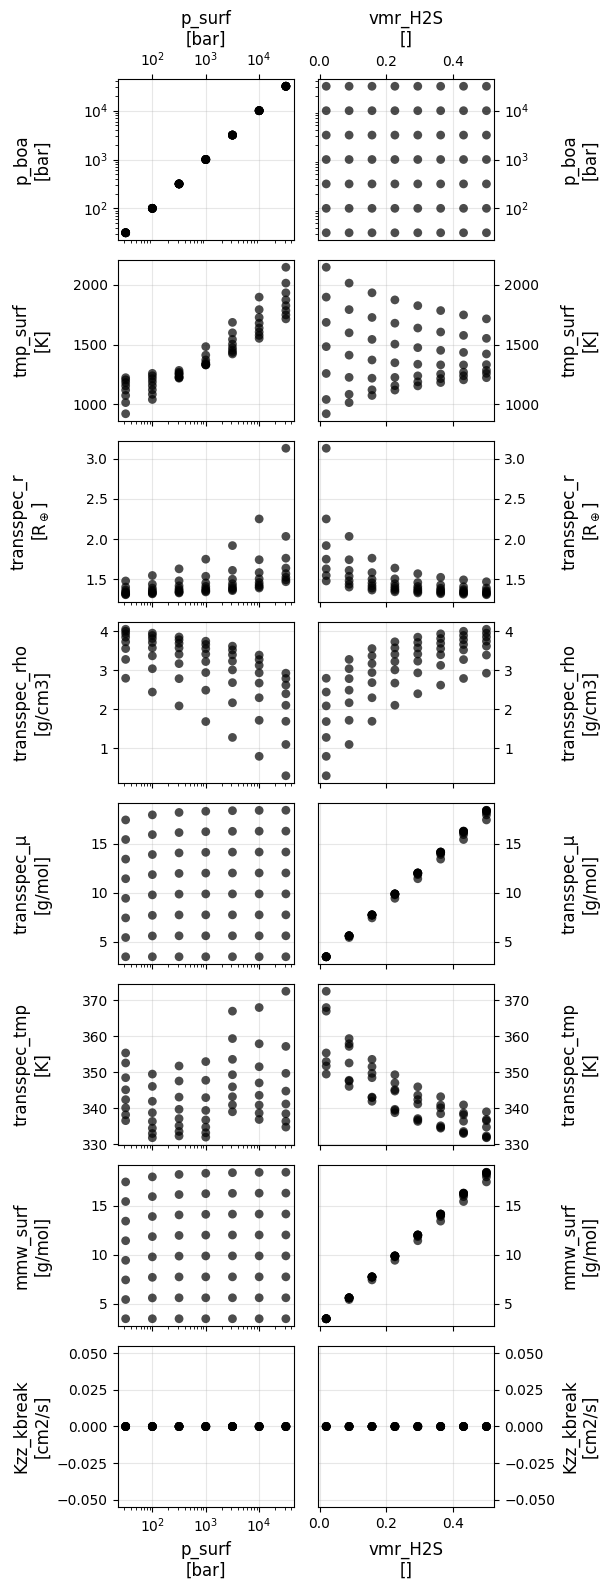

In [20]:

# Create figure with subplots
fig, axes = plt.subplots(len(output_vars), len(input_vars),
                        figsize=(3*len(input_vars), 2*len(output_vars)))

# If only one row or column, ensure axes is 2D
if len(output_vars) == 1:
    axes = axes.reshape(1, -1)
if len(input_vars) == 1:
    axes = axes.reshape(-1, 1)

# Plot each combination
for i, output_var in enumerate(output_vars):
    for j, input_var in enumerate(input_vars):
        ax = axes[i, j]

        x = np.array(data[input_var])
        try:
            x *= units[input_var][0]
            xunit = units[input_var][2]

            if units[input_var][1]:
                ax.set_xscale("log")
        except KeyError:
            xunit = ""

        y = np.array(data[output_var])
        try:
            y *= units[output_var][0]
            yunit = units[output_var][2]
            if units[output_var][1]:
                ax.set_yscale("log")
        except KeyError:
            yunit = ""


        # Create scatter plot
        scatter = ax.scatter(x,y, zorder=3, alpha=0.7, s=40,
                                edgecolor='none', linewidth=0.5, color='k')

        # Set labels and title
        if (i == len(output_vars)-1) or (i == 0):
            ax.set_xlabel(f"{input_var}\n[{xunit}]", fontsize=12)
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        else:
            ax.set_xticklabels([])

        if (j == len(input_vars)-1) or (j == 0):
            ax.set_ylabel(f"{output_var}\n[{yunit}]", fontsize=12)
            if (j == len(input_vars)-1):
                ax.yaxis.set_label_position('right')
                ax.yaxis.set_tick_params(right=True, labelright=True, left=False, labelleft=False)
        else:
            ax.set_yticklabels([])

        # Add grid
        ax.grid(True, alpha=0.3, zorder=-2)

        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
fig.align_ylabels()
fig.align_xlabels()

# Save the plot
fig.savefig(os.path.join(output_dir, "parameter_response_matrix.pdf"),
            dpi=300, bbox_inches='tight')

# Display the plot
plt.show()